# tril/triu/diag indices

In [2]:
import numpy as np
X = np.arange(25).reshape(5, 5)
# Main diagonal indices
np.diag_indices(5, ndim=2)

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

In [3]:
np.diag_indices_from(X)

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

In [4]:
# Higher dimensional diagonal indices
np.diag_indices(3, ndim=3)

(array([0, 1, 2]), array([0, 1, 2]), array([0, 1, 2]))

In [6]:
# Tril indices
np.tril_indices(5, k=-1)

(array([1, 2, 2, 3, 3, 3, 4, 4, 4, 4]), array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3]))

In [5]:
np.tril_indices_from(X, k=-1)

(array([1, 2, 2, 3, 3, 3, 4, 4, 4, 4]), array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3]))

# Changing Elements Using the `where` Operation

Text(0.5, 1.0, 'Thresholded')

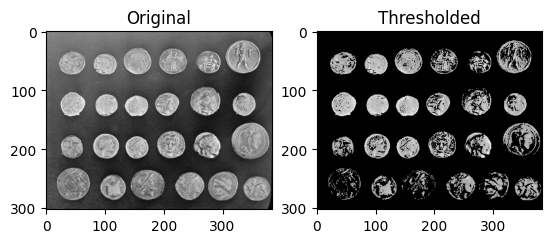

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import skimage # pip install scikit-image==0.21.0
image = skimage.data.coins()
# image thresholding to remove background
image_thresh = np.where(image > 150, image, 0)
# plot the images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(image_thresh, cmap="gray")
axs[1].set_title("Thresholded")
fig.savefig("../assets/chapter-5/coin-threshold.png", dpi=300, bbox_inches='tight')

# Use Multiplication to Apply Masks

In [8]:
import numpy as np
X = np.arange(25).reshape(5, 5) + 1
X

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25]])

In [9]:
# Create the cross-like mask
mask = np.zeros_like(X)
np.fill_diagonal(mask, 1)
mask = mask[:, ::-1] # now the anti-diagonal is filled
np.fill_diagonal(mask, 1)
mask

array([[1, 0, 0, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [1, 0, 0, 0, 1]])

In [10]:
# Apply the mask with multiplication
# equivalent to np.where(mask > 0, X, 0)
X = X * mask
X

array([[ 1,  0,  0,  0,  5],
       [ 0,  7,  0,  9,  0],
       [ 0,  0, 13,  0,  0],
       [ 0, 17,  0, 19,  0],
       [21,  0,  0,  0, 25]])

# Use Arithmetic Operations as Boolean Operations to Apply and Combine Masks

In [11]:
import numpy as np

def combine_mask(a, b=None, operation="not"):
    if operation != "not":
        assert b is not None, f"b cannot be None for '{operation}' operation"
    if operation == "not": # b is ignored
        return 1 - a
    elif operation == "and":
        return a * b
    elif operation == "or":
        return np.minimum(a + b, 1)
    elif operation == "xor":
        return np.abs(a - b)
    else:
        raise(ValueError(f"Unrecognized operation {operation}."))

In [16]:
import numpy as np
import tensorflow as tf
mask_a = np.array([1, 0, 0, 1, 0]) 
mask_b = np.array([0, 0, 0, 1, 1])

mask_a_bool = np.array([True, False, False, True, False])
mask_b_bool = np.array([False, False, False, True, True])

print("not:", tf.math.logical_not(mask_a_bool).numpy().astype(int))
print("and:", tf.math.logical_and(mask_a_bool, mask_b_bool).numpy().astype(int))
print("or:", tf.math.logical_or(mask_a_bool, mask_b_bool).numpy().astype(int))
print("xor:", tf.math.logical_xor(mask_a_bool, mask_b_bool).numpy().astype(int))

not: [0 1 1 0 1]
and: [0 0 0 1 0]
or: [1 0 0 1 1]
xor: [1 0 0 0 1]


In [15]:
print("not:", combine_mask(mask_a, operation="not"))
print("and:", combine_mask(mask_a, mask_b, operation="and"))
print("or:", combine_mask(mask_a, mask_b, operation="or"))
print("xor:", combine_mask(mask_a, mask_b, operation="xor"))

not: [0 1 1 0 1]
and: [0 0 0 1 0]
or: [1 0 0 1 1]
xor: [1 0 0 0 1]


# Select Elements Based on Masking

In [17]:
import numpy as np

X = np.array([5, 3, 2, 6, 9])
mask = np.mod(X, 2) == 0 # even number
assert np.allclose(
    X[mask], # array([2, 6])
    np.compress(mask, X) # array([2, 6])
)
X[mask]

array([2, 6])

In [24]:
# In Torch
import torch
X = torch.arange(25).reshape(5, 5) + 1
X

tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10],
        [11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25]])

In [25]:
mask = torch.ones_like(X, dtype=bool)
mask.fill_diagonal_(False)
X_masked = torch.masked_select(X, mask).reshape(5, 4)
X_masked

tensor([[ 2,  3,  4,  5],
        [ 6,  8,  9, 10],
        [11, 12, 14, 15],
        [16, 17, 18, 20],
        [21, 22, 23, 24]])

# Case Study: Top-k Masking

In [29]:
import numpy as np
def top_k_masking(y, top_k, masked_value=0):
    """Mask the input and retain only top_k values."""
    # Get top k indices
    index = np.argsort(y)[..., -top_k:][..., ::-1]
    # Initialize the zeros mask
    mask = np.zeros_like(y)
    # scatter the indices (in-place)
    np.put_along_axis(mask, index, 1, axis=-1)
    # Adjust values such that the masked elements
    # are replaced with masked_value
    y_masked = y * mask + masked_value * (1 - mask)
    return y_masked


y = np.array([
    [1, 5, 2, 3, 8, 7], 
    [2, 6, 3, 1, 9, 4]
])

top_k_masking(y, top_k=3, masked_value=0)

array([[0, 5, 0, 0, 8, 7],
       [0, 6, 0, 0, 9, 4]])

# Padding

In [30]:
import numpy as np
import tensorflow as tf
import torch.nn.functional as F
# shape(3, 4)
X = np.array([
    [7, 1, 4, 4],
    [5, 7, 6, 4],
    [7, 3, 1, 2],
])
# padding zeros -> shape (6, 6)
y_np = np.pad(X, [(3, 0), (0, 2)], mode="constant", constant_values=0)
y_tf = tf.pad(X, [(3, 0), (0, 2)], mode="CONSTANT", constant_values=0)
y_torch = F.pad(
    torch.tensor(X), [0, 2, 3, 0], mode="constant", value=0
)
y_np

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [7, 1, 4, 4, 0, 0],
       [5, 7, 6, 4, 0, 0],
       [7, 3, 1, 2, 0, 0]])

In [31]:
y_tf

<tf.Tensor: shape=(6, 6), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [7, 1, 4, 4, 0, 0],
       [5, 7, 6, 4, 0, 0],
       [7, 3, 1, 2, 0, 0]])>

In [32]:
y_torch

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [7, 1, 4, 4, 0, 0],
        [5, 7, 6, 4, 0, 0],
        [7, 3, 1, 2, 0, 0]])

Multi-dimensional padding in NumPy

In [33]:
import numpy as np
# shape (3, 4)
X = np.array([
    [7, 1, 4, 4],
    [5, 7, 6, 4],
    [7, 3, 1, 2],
])

# padding starts with 0 and ends with -1 for each dimension
y = np.pad(X, [(0, 1), (2, 0)], mode="constant", constant_values=(0, -1))
y

array([[ 0,  0,  7,  1,  4,  4],
       [ 0,  0,  5,  7,  6,  4],
       [ 0,  0,  7,  3,  1,  2],
       [ 0,  0, -1, -1, -1, -1]])

In [34]:
# padding row start with 0, row end with -1
# padding column start with -2, column end with -3
y = np.pad(
    X, [(1, 1), (1, 1)], mode="constant", constant_values=[(0, -1), (-2, -3)]
)
y

array([[-2,  0,  0,  0,  0, -3],
       [-2,  7,  1,  4,  4, -3],
       [-2,  5,  7,  6,  4, -3],
       [-2,  7,  3,  1,  2, -3],
       [-2, -1, -1, -1, -1, -3]])

Reflect padding

In [35]:
import numpy as np
import tensorflow as tf
import torch.nn.functional as F
X = np.array([
    [7, 1, 4, 4],
    [5, 7, 6, 4],
    [7, 3, 1, 2],
])
y_np = np.pad(X, [(1, 2), (1, 2)], mode="reflect")
y_tf = tf.pad(X, [(1, 2), (1, 2)], mode="REFLECT")
y_torch = F.pad(
    torch.tensor(X[None, :, :], dtype=float),
    [1, 2, 1, 2],
    mode="reflect"
)[0, :, :]

In [36]:
y_np

array([[7, 5, 7, 6, 4, 6, 7],
       [1, 7, 1, 4, 4, 4, 1],
       [7, 5, 7, 6, 4, 6, 7],
       [3, 7, 3, 1, 2, 1, 3],
       [7, 5, 7, 6, 4, 6, 7],
       [1, 7, 1, 4, 4, 4, 1]])

In [37]:
y_tf

<tf.Tensor: shape=(6, 7), dtype=int64, numpy=
array([[7, 5, 7, 6, 4, 6, 7],
       [1, 7, 1, 4, 4, 4, 1],
       [7, 5, 7, 6, 4, 6, 7],
       [3, 7, 3, 1, 2, 1, 3],
       [7, 5, 7, 6, 4, 6, 7],
       [1, 7, 1, 4, 4, 4, 1]])>

In [38]:
y_torch

tensor([[7., 5., 7., 6., 4., 6., 7.],
        [1., 7., 1., 4., 4., 4., 1.],
        [7., 5., 7., 6., 4., 6., 7.],
        [3., 7., 3., 1., 2., 1., 3.],
        [7., 5., 7., 6., 4., 6., 7.],
        [1., 7., 1., 4., 4., 4., 1.]], dtype=torch.float64)

Symmetric padding

In [39]:
import numpy as np
import tensorflow as tf
X = np.array([
    [7, 1, 4, 4],
    [5, 7, 6, 4],
    [7, 3, 1, 2],
])
y_np = np.pad(X, [(1, 2), (1, 2)], mode="symmetric")
y_tf = tf.pad(X, [(1, 2), (1, 2)], mode="SYMMETRIC")

In [40]:
y_np

array([[7, 7, 1, 4, 4, 4, 4],
       [7, 7, 1, 4, 4, 4, 4],
       [5, 5, 7, 6, 4, 4, 6],
       [7, 7, 3, 1, 2, 2, 1],
       [7, 7, 3, 1, 2, 2, 1],
       [5, 5, 7, 6, 4, 4, 6]])

In [41]:
y_tf

<tf.Tensor: shape=(6, 7), dtype=int64, numpy=
array([[7, 7, 1, 4, 4, 4, 4],
       [7, 7, 1, 4, 4, 4, 4],
       [5, 5, 7, 6, 4, 4, 6],
       [7, 7, 3, 1, 2, 2, 1],
       [7, 7, 3, 1, 2, 2, 1],
       [5, 5, 7, 6, 4, 4, 6]])>

replicate padding

In [44]:
import numpy as np
import torch
X = np.array([
    [7, 1, 4, 4],
    [5, 7, 6, 4],
    [7, 3, 1, 2],
])
y_np = np.pad(X, [(1, 2), (1, 2)], mode="edge")
y_torch = F.pad(
    torch.tensor(X[None, :, :], dtype=float),
    [1, 2, 1, 2],
    mode="replicate"
)[0, :, :]

In [45]:
y_np

array([[7, 7, 1, 4, 4, 4, 4],
       [7, 7, 1, 4, 4, 4, 4],
       [5, 5, 7, 6, 4, 4, 4],
       [7, 7, 3, 1, 2, 2, 2],
       [7, 7, 3, 1, 2, 2, 2],
       [7, 7, 3, 1, 2, 2, 2]])

In [43]:
y_torch

tensor([[7., 7., 1., 4., 4., 4., 4.],
        [7., 7., 1., 4., 4., 4., 4.],
        [5., 5., 7., 6., 4., 4., 4.],
        [7., 7., 3., 1., 2., 2., 2.],
        [7., 7., 3., 1., 2., 2., 2.],
        [7., 7., 3., 1., 2., 2., 2.]], dtype=torch.float64)

Wrap padding

In [46]:
import numpy as np
import torch
X = np.array([
    [7, 1, 4, 4],
    [5, 7, 6, 4],
    [7, 3, 1, 2],
])
y_np = np.pad(X, [(1, 2), (1, 2)], mode="wrap")
# padding rows
y_torch = F.pad(
    torch.tensor(X, dtype=float).t()[None, :, :], [1, 2], mode="circular"
)
# padding columns
y_torch = F.pad(torch.swapaxes(y_torch, 1, 2), [1, 2], mode="circular")

In [47]:
y_np

array([[2, 7, 3, 1, 2, 7, 3],
       [4, 7, 1, 4, 4, 7, 1],
       [4, 5, 7, 6, 4, 5, 7],
       [2, 7, 3, 1, 2, 7, 3],
       [4, 7, 1, 4, 4, 7, 1],
       [4, 5, 7, 6, 4, 5, 7]])

In [48]:
y_torch

tensor([[[2., 7., 3., 1., 2., 7., 3.],
         [4., 7., 1., 4., 4., 7., 1.],
         [4., 5., 7., 6., 4., 5., 7.],
         [2., 7., 3., 1., 2., 7., 3.],
         [4., 7., 1., 4., 4., 7., 1.],
         [4., 5., 7., 6., 4., 5., 7.]]], dtype=torch.float64)

# Case Study: Padding in Convolutional Neural Networks

In [49]:
import tensorflow as tf
X = tf.constant([
    [5, 3, 2, 7],
    [4, 1, 3, 7],
    [1, 4, 4, 1],
    [7, 6, 4, 2],
], dtype=tf.float32)[None, :, :, None]

Filters = tf.constant([
    [0, 2], 
    [1, 1]
], dtype=tf.float32)[:, :, None, None]

y_valid = tf.nn.conv2d(
    X,
    Filters,
    1,
    "VALID",
    data_format='NHWC',
    dilations=None,
    name=None
)
assert y_valid.shape[1] == X.shape[1] - 1
assert y_valid.shape[2] == X.shape[2] - 1

y_same = tf.nn.conv2d(
    X,
    Filters,
    1,
    "SAME",
    data_format='NHWC',
    dilations=None,
    name=None
)
assert y_same.shape[1] == X.shape[1]
assert y_same.shape[2] == X.shape[2]

# Case Study: Truncate or Pad Sequence to Desired Length

In [50]:
import numpy as np
def align_lengths(X, y):
    """Align y to the length (axis=1) of X."""
    # Get the desired length
    X_len = X.shape[1]
    # Compute pad_size. 
    # No padding (pad_size=0) if y length is enough
    pad_size = max(X_len - y.shape[1], 0)
    # Pad if not enough
    y = np.pad(y, [(0, 0), (0, pad_size)])
    # Truncate if y is too long
    y = y[:, :X_len]

    return y

In [51]:
X1 = np.random.rand(16, 50)
X2 = np.random.rand(16, 30)
y = np.random.rand(16, 37)

y1 = align_lengths(X1, y)
assert np.allclose(X1.shape, y1.shape)
print(y1.shape)
y2 = align_lengths(X2, y)
assert np.allclose(X2.shape, y2.shape)
print(y2.shape)

(16, 50)
(16, 30)


# Scaled-Dot Product Attention

### Illustration of Attention mask

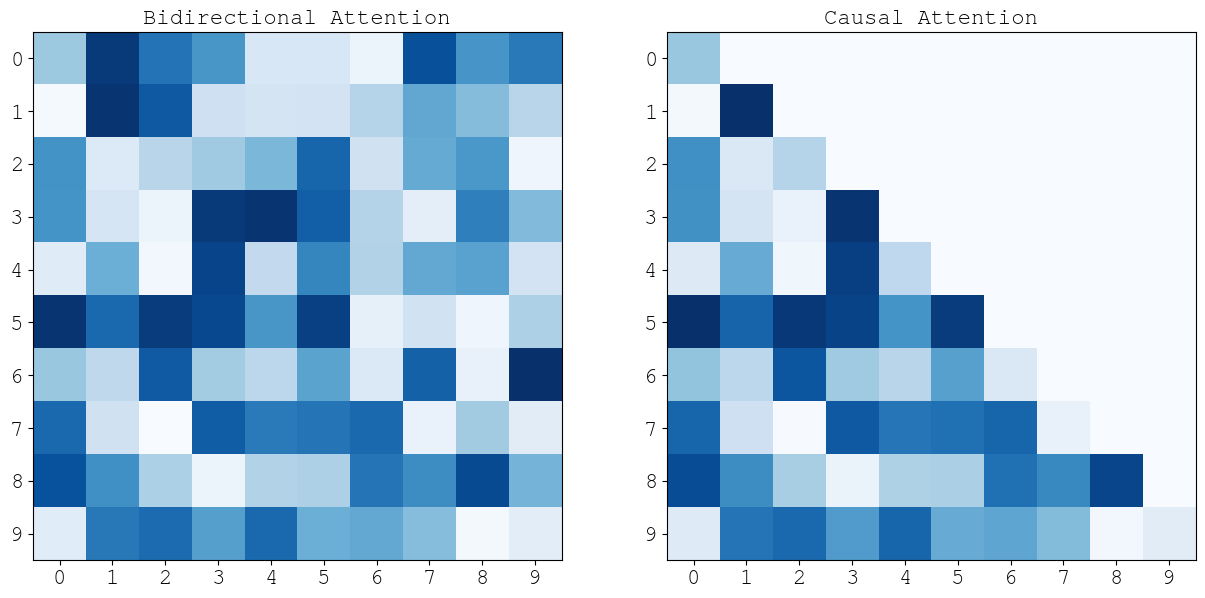

In [13]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
np.random.seed(42)
X = np.random.rand(10, 10) * 0.25

ax = axs[0]
ax.imshow(X, cmap="Blues")
ax.set_title("Bidirectional Attention", fontname="TeX Gyre Cursor", fontsize=16)
ax.set_xticks(np.arange(10), labels=[str(ii) for ii in range(10)], fontname="TeX Gyre Cursor", fontsize=16)
ax.set_yticks(np.arange(10), labels=[str(ii) for ii in range(10)], fontname="TeX Gyre Cursor", fontsize=16)
ax = axs[1]
ax.imshow(np.tril(X), cmap="Blues")
ax.set_title("Causal Attention", fontname="TeX Gyre Cursor", fontsize=16)
ax.set_xticks(np.arange(10), labels=[str(ii) for ii in range(10)], fontname="TeX Gyre Cursor", fontsize=16)
ax.set_yticks(np.arange(10), labels=[str(ii) for ii in range(10)], fontname="TeX Gyre Cursor", fontsize=16)
fig.savefig("../assets/chapter-5/attention-mask.pdf", bbox_inches="tight", pad_inches=0)

In [53]:
import tensorflow as tf
from keras.activations import softmax

def scaled_dot_product_attention(
    query, key, value, mask=None, causal=True, droprate=0.0
):
    """
    Use the dense layer output from query, key, value,
    respectively, as input for attention

    Parameters:
    -----------
    * query: (..., l_q,        depth_src)
    * key:   (..., l_k == l_v, depth_src)
    * value: (..., l_v == l_k, depth_out)
    * mask: Float tensor of 0s and 1s, with
            shape broadcastable to (..., l_q, l_k).
    * causal: bool. Whether or not to apply causal attention masking.
    * droprate: dropout rate.

    - depth_*: depth x num_heads = embed_dim, which
               can be different, but are usually the same.
    - l_*: are lengths of input sequences which can be different,
           but are usually the same

    Returns:
    -----------
    * attention: attention score (..., l_q, depth_out)
    * weights: weights of the value when summing the value (..., l_q, l_k)
    """
    # Cosine/dot product similarity
    # Q K.T, (..., l_q, l_k)
    logit_score = tf.matmul(query, key, transpose_b=True)

    # scale by dimension of key
    d_k = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_logit_score = logit_score / tf.sqrt(d_k)  # (..., l_q, l_k)

    # Masking the region by a large negative number (est. -inf)
    if mask is not None:
        scaled_logit_score += mask * -1e9  # (..., l_q, l_k)
    if causal:
        l_q = tf.shape(query)[-2]
        l_k = tf.shape(key)[-2]
        # creates an upper triangular mask to retain lower triangular matrix
        causal_mask = 1 - tf.linalg.band_part(
            tf.ones((l_q, l_k), tf.float32), -1, 0
        )
        scaled_logit_score += causal_mask * -1e9

    # weights: softmax normalization
    weights = softmax(scaled_logit_score, axis=-1)
    # Add dropout
    weights = tf.nn.dropout(weights, droprate)

    # attention (..., l_q, depth_out)
    attention = tf.matmul(weights, value)

    return attention, weights

In [54]:
query = key = value = tf.random.uniform((8, 50, 128))
key = tf.random.uniform((8, 25, 128))
value = tf.random.uniform((8, 25, 256))
attention, weights = scaled_dot_product_attention(
    query, key, value, mask=None, causal=True
)
attention

<tf.Tensor: shape=(8, 50, 256), dtype=float32, numpy=
array([[[1.80709365e-04, 3.08738177e-04, 7.12555542e-04, ...,
         7.57671776e-04, 2.72464822e-04, 5.27725439e-04],
        [1.10276311e-03, 1.39345857e-03, 2.12453795e-03, ...,
         1.13441411e-03, 1.13921775e-03, 8.03544419e-04],
        [1.00661849e-03, 1.93850382e-03, 1.80943217e-03, ...,
         1.40610815e-03, 9.88046173e-04, 8.78950232e-04],
        ...,
        [1.27640311e-02, 1.04348594e-02, 1.13991583e-02, ...,
         1.33943111e-02, 1.03869569e-02, 1.30961938e-02],
        [1.35781812e-02, 1.07527990e-02, 1.17813274e-02, ...,
         1.39015056e-02, 1.09303398e-02, 1.36850337e-02],
        [1.20211951e-02, 9.45147593e-03, 1.03107197e-02, ...,
         1.25002135e-02, 9.72945802e-03, 1.20976185e-02]],

       [[2.41855494e-04, 9.03279055e-04, 7.99477391e-04, ...,
         5.24850620e-04, 6.10889168e-04, 8.85359012e-04],
        [1.27250282e-03, 1.50989043e-03, 1.53639948e-03, ...,
         8.06582568e-04, 8.18

# Variable-Length Range via Masking

In [56]:
from typing import List
import numpy as np

def ragged_range(n: List[int], pad=-1, flatten=True):
    """Implement ragged matrix using a dense matrix with paddings."""
    # Find the maximum length
    n = np.array(n)
    max_n = np.max(n)
    # Construct and repeat arange
    r = np.arange(max_n)[None, :]
    # Masking with broadcasting
    mask = r >= n[:, None]
    r = np.where(mask, pad, r)
    # Flatten
    if flatten:
        # Flatten
        r = np.ravel(r)
        # Remove padding values
        r = np.compress(r != pad, r)
    
    return r 

In [57]:
n = [2, 5, 4]
ragged_range(n)

array([0, 1, 0, 1, 2, 3, 4, 0, 1, 2, 3])

In [58]:
from typing import List
import tensorflow as tf

def tf_ragged_range(n: tf.Tensor, pad=-1, flatten=True, dtype=tf.int64):
    """Implement ragged matrix using a dense matrix with paddings."""
    # Find the maximum length
    n = tf.cast(n, dtype)
    pad = tf.cast(pad, dtype)
    max_n = tf.reduce_max(n)
    # Construct and repeat arange
    r = tf.expand_dims(tf.range(max_n, dtype=dtype), axis=0)
    # Masking with broadcasting
    mask = r >= tf.expand_dims(n, axis=1)
    r = tf.where(mask, pad, r)
    # Flatten
    if flatten:
        # Flatten
        r = tf.reshape(r, (-1, ))
        # Remove padding values
        r = tf.boolean_mask(r, r!= pad)
    
    return r

In [59]:
tf_ragged_range(n)

<tf.Tensor: shape=(11,), dtype=int64, numpy=array([0, 1, 0, 1, 2, 3, 4, 0, 1, 2, 3])>

# Length Regulator Module of FastSpeech2

In [60]:
import tensorflow as tf
from keras import Input, Model
from keras.layers import Layer

# Import functions that we implemented previously
# from .utils import tf_ragged_range


class LengthRegulator(Layer):
    """FastSpeech Length Regulator"""
    def __init__(
        self,
        num_channels=256,
        max_len=-1,
        name="length_regulator",
    ):
        super(LengthRegulator, self).__init__(name=name)
        # embedding size
        self.num_channels = num_channels
        # maximum length of the audio signal
        # if -1, determine the audio signal from inputs dynamically
        self.max_len = max_len

    def call(
        self,
        token_embeddings,
        spect_durations,
        training=False,
    ):
        """
        Layer call method
        * token_embeddings : (batch_size, seq_len, num_channels)
        * spect_durations : (batch_size, seq_len), where the value of
            the durations are expressed as number of audio sample frames
        * training : bool, optional, by default False

        The length of the returned sequence after length regulator is the maximum
        of the sum of the durations across the batch.
        For example, [[2, 8, 0], [3, 1, 4], [2, 0, 0]].  Then the durations are
        [10, 8, 2], and the output sequence length is 10.
        The mask will indicate the valid positions of the output.
        """
        # Preprocess durations
        spect_durations = tf.cast(tf.math.round(spect_durations), tf.int64)
        durations = tf.math.maximum(spect_durations, 1)
        durations = tf.cast(durations, tf.int64)

        # Save some shapes
        batch_size = tf.shape(token_embeddings)[0]
        seq_len = tf.shape(durations)[1]
        batch_duration = tf.reduce_sum(durations, axis=1)
        max_durations = tf.maximum(tf.reduce_max(batch_duration), self.max_len)
        # reshaping to (batch_size x seq_len, num_channels)
        hidden_states = tf.reshape(
            token_embeddings, (-1, self.num_channels)
        )
        durations = tf.reshape(durations, (-1,))

        # repeat: (sum(spec_durations), hidden_size)
        hidden_states = tf.repeat(hidden_states, durations, axis=0)

        # scatter the repeated hidden states to the right positions
        row_indices = tf.repeat(
            tf.repeat(tf.range(batch_size, dtype=tf.int64), seq_len),
            durations,
        )
        col_indices = tf_ragged_range(batch_duration)
        indices = tf.stack([row_indices, col_indices], axis=1)
        output = tf.scatter_nd(
            indices,
            hidden_states,
            shape=(batch_size, max_durations, self.num_channels),
        )
        # create output mask
        mask_batch_duration = tf.reduce_sum(spect_durations, axis=1)
        mask_values = tf.ones(
            [tf.reduce_sum(mask_batch_duration), 1],
            dtype=tf.float32,
        )
        mask_row_indices = tf.repeat(
            tf.range(batch_size, dtype=tf.int64), mask_batch_duration
        )
        mask_col_indices = tf_ragged_range(mask_batch_duration)
        mask_indices = tf.stack([mask_row_indices, mask_col_indices], axis=1)
        mask = tf.scatter_nd(
            mask_indices,
            mask_values,
            shape=(batch_size, max_durations, 1),
        )

        # Further truncate any potential padding zeros
        tight_size = tf.cast(
            tf.reduce_max(tf.reduce_sum(mask, axis=1)), tf.int64
        )
        output = output[:, :tight_size, :]
        mask = mask[:, :tight_size, :]

        return output, mask

    @property
    def model(self):
        text_embeddings = Input((None, self.num_channels), dtype=tf.float32)
        spect_durations = Input((None,), dtype=tf.float32)
        model = Model(
            inputs=[text_embeddings, spect_durations],
            outputs=self.call(
                text_embeddings, spect_durations, training=False
            ),
        )
        return model

In [66]:
# Initialize the model layer
layer = LengthRegulator(num_channels=256)
print(layer.model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 tf.math.round_1 (TFOpLambd  (None, None)                 0         ['input_4[0][0]']             
 a)                                                                                               
                                                                                                  
 tf.cast_5 (TFOpLambda)      (None, None)                 0         ['tf.math.round_1[0][0]']     
                                                                                                  
 tf.math.reduce_sum_5 (TFOp  (None,)                      0         ['tf.cast_5[0][0]']     

 tf.repeat_7 (TFOpLambda)    (None,)                      0         ['tf.range_6[0][0]',          
                                                                     'tf.math.reduce_sum_5[0][0]']
                                                                                                  
 tf.compat.v1.boolean_mask_  (None,)                      0         ['tf.reshape_13[0][0]',       
 3 (SlicingOpLambda)                                                 'tf.__operators__.ne_3[0][0]'
                                                                    ]                             
                                                                                                  
 tf.math.reduce_sum_6 (TFOp  ()                           0         ['tf.math.reduce_sum_5[0][0]']
 Lambda)                                                                                          
                                                                                                  
 tf.range_

In [67]:
# Make up two inputs
# First input has 4 words, and second input has 7 words
spect_durations = tf.constant([
    [2, 4, 5, 6, 0, 0, 0],
    [1, 3, 6, 2, 8, 4, 1],
])
# Faking the token embedding vectors with random values
# Masking out the part that should not correspond to any utterance
input_mask = tf.cast(spect_durations > 0, tf.float32)[:, :, None]
token_embeddings = tf.random.uniform((2, 7, 256)) * input_mask

# Pass the inputs through the layer
output, mask = layer(token_embeddings, spect_durations)

In [68]:
# Check the batch size are kept
assert output.shape[0] == token_embeddings.shape[0]
assert output.shape[1] == tf.reduce_max(tf.reduce_sum(spect_durations, axis=1))
assert output.shape[2] == token_embeddings.shape[2]

In [69]:
# Checking masking indicates valid indices
assert tf.experimental.numpy.allclose(
    tf.reduce_sum(mask, axis=(1, 2)).numpy(),
    tf.reduce_sum(spect_durations, axis=1).numpy()
)